<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/k-fold/Alexnet_stratified_k_hold_8_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install albumentations

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
import albumentations as A
from sklearn.metrics import classification_report

In [111]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [112]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [113]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [116]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [117]:
net = torchvision.models.alexnet(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.6094 Acc: 0.7042
valLoss: 0.5309 Acc: 0.8000
trainLoss: 0.5600 Acc: 0.7417
valLoss: 0.5197 Acc: 0.8000
trainLoss: 0.5633 Acc: 0.7458
valLoss: 0.5030 Acc: 0.8000
trainLoss: 0.5507 Acc: 0.7500
valLoss: 0.5228 Acc: 0.8333
trainLoss: 0.5561 Acc: 0.7417
valLoss: 0.4644 Acc: 0.8000
trainLoss: 0.5293 Acc: 0.7458
valLoss: 0.4550 Acc: 0.8000
trainLoss: 0.5226 Acc: 0.7542
valLoss: 0.4399 Acc: 0.8000
trainLoss: 0.5179 Acc: 0.7500
valLoss: 0.4420 Acc: 0.8167
trainLoss: 0.5051 Acc: 0.7458
valLoss: 0.4266 Acc: 0.8167
trainLoss: 0.5080 Acc: 0.7458
valLoss: 0.4607 Acc: 0.9000
trainLoss: 0.4931 Acc: 0.7542
valLoss: 0.4193 Acc: 0.8500
trainLoss: 0.4996 Acc: 0.7583
valLoss: 0.4574 Acc: 0.8667
trainLoss: 0.4838 Acc: 0.8000
valLoss: 0.4381 Acc: 0.8833
trainLoss: 0.4880 Acc: 0.7833
valLoss: 0.4111 Acc: 0.9000
trainLoss: 0.4864 Acc: 0.7708
valLoss: 0.4274 Acc: 0.8833
trainLoss: 0.4729 Acc: 0.8042
valLoss: 0.4171 Acc: 0.9000
trainLoss: 0.4920 Acc: 0.766

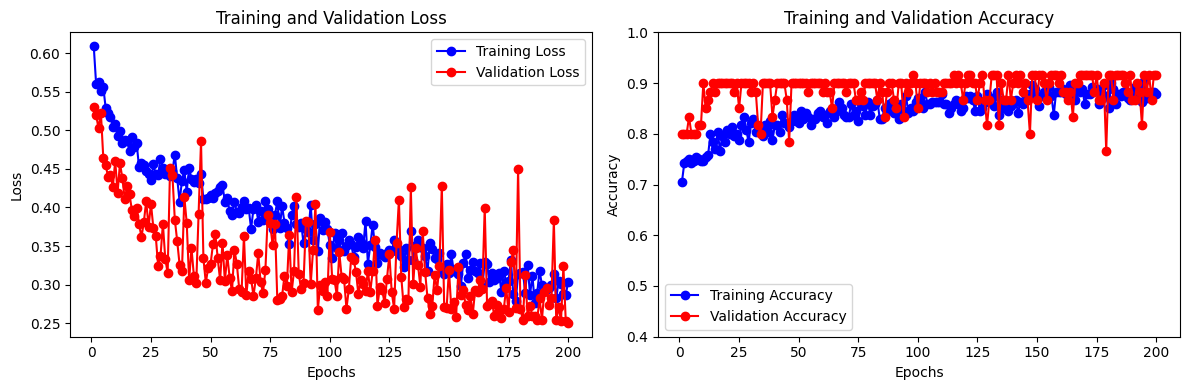

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.94      0.96      0.95        47
         out       0.83      0.77      0.80        13

    accuracy                           0.92        60
   macro avg       0.89      0.86      0.87        60
weighted avg       0.91      0.92      0.92        60

==========Cross Validation Fold 2==========
trainLoss: 0.6610 Acc: 0.6042
valLoss: 0.4951 Acc: 0.7667
trainLoss: 0.5387 Acc: 0.7708
valLoss: 0.4119 Acc: 0.7833
trainLoss: 0.4957 Acc: 0.7792
valLoss: 0.3827 Acc: 0.7833
trainLoss: 0.4669 Acc: 0.7917
valLoss: 0.3705 Acc: 0.8500
trainLoss: 0.4268 Acc: 0.8333
valLoss: 0.3571 Acc: 0.8333
trainLoss: 0.4203 Acc: 0.8167
valLoss: 0.4106 Acc: 0.8333
trainLoss: 0.4137 Acc: 0.8250
valLoss: 0.3393 Acc: 0.8667
trainLoss: 0.4170 Acc: 0.8417
valLoss: 0.3378 Acc: 0.8833
trainLoss: 0.4024 Acc: 0.8458
valLoss: 0.3263 Acc: 0.8667
trainLoss: 0.3907 Acc: 0.8417
valLoss: 0.3225 Acc: 0.8667
trainLoss: 0.3827 Acc: 0

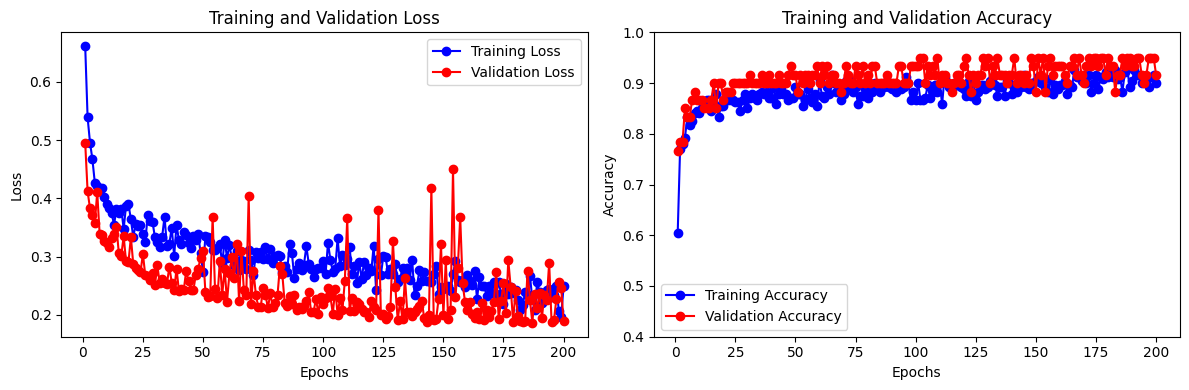

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.96      0.94      0.95        48
         out       0.77      0.83      0.80        12

    accuracy                           0.92        60
   macro avg       0.86      0.89      0.87        60
weighted avg       0.92      0.92      0.92        60

==========Cross Validation Fold 3==========
trainLoss: 0.5550 Acc: 0.7250
valLoss: 0.4289 Acc: 0.8833
trainLoss: 0.4083 Acc: 0.8500
valLoss: 0.4024 Acc: 0.9333
trainLoss: 0.4027 Acc: 0.8417
valLoss: 0.3481 Acc: 0.9333
trainLoss: 0.3549 Acc: 0.8458
valLoss: 0.4483 Acc: 0.8167
trainLoss: 0.3473 Acc: 0.8708
valLoss: 0.3445 Acc: 0.9167
trainLoss: 0.3194 Acc: 0.8875
valLoss: 0.3770 Acc: 0.8667
trainLoss: 0.3252 Acc: 0.8833
valLoss: 0.3021 Acc: 0.9333
trainLoss: 0.3088 Acc: 0.8875
valLoss: 0.3485 Acc: 0.8667
trainLoss: 0.3109 Acc: 0.8667
valLoss: 0.2872 Acc: 0.9333
trainLoss: 0.2809 Acc: 0.8875
valLoss: 0.3223 Acc: 0.8500
trainLoss: 0.2788 Acc: 0

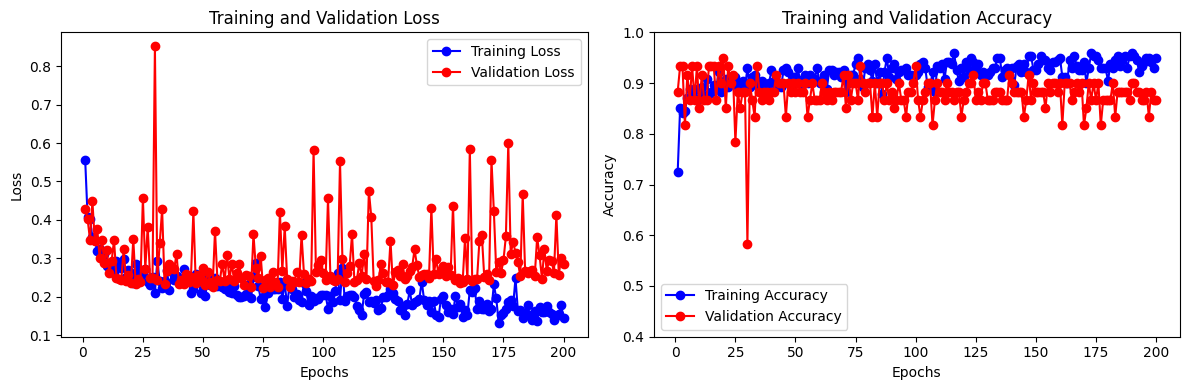

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.93      0.88      0.90        42
         out       0.75      0.83      0.79        18

    accuracy                           0.87        60
   macro avg       0.84      0.86      0.85        60
weighted avg       0.87      0.87      0.87        60

==========Cross Validation Fold 4==========
trainLoss: 0.5332 Acc: 0.7375
valLoss: 0.5047 Acc: 0.8167
trainLoss: 0.4318 Acc: 0.8083
valLoss: 0.4281 Acc: 0.8000
trainLoss: 0.3474 Acc: 0.8583
valLoss: 0.3877 Acc: 0.8500
trainLoss: 0.3494 Acc: 0.8958
valLoss: 0.3516 Acc: 0.8500
trainLoss: 0.3209 Acc: 0.8917
valLoss: 0.3461 Acc: 0.8333
trainLoss: 0.2988 Acc: 0.9000
valLoss: 0.3286 Acc: 0.8500
trainLoss: 0.2559 Acc: 0.9417
valLoss: 0.3164 Acc: 0.8833
trainLoss: 0.2438 Acc: 0.9042
valLoss: 0.3100 Acc: 0.8500
trainLoss: 0.2476 Acc: 0.9167
valLoss: 0.3046 Acc: 0.8667
trainLoss: 0.2445 Acc: 0.9083
valLoss: 0.3046 Acc: 0.8833
trainLoss: 0.2372 Acc: 0

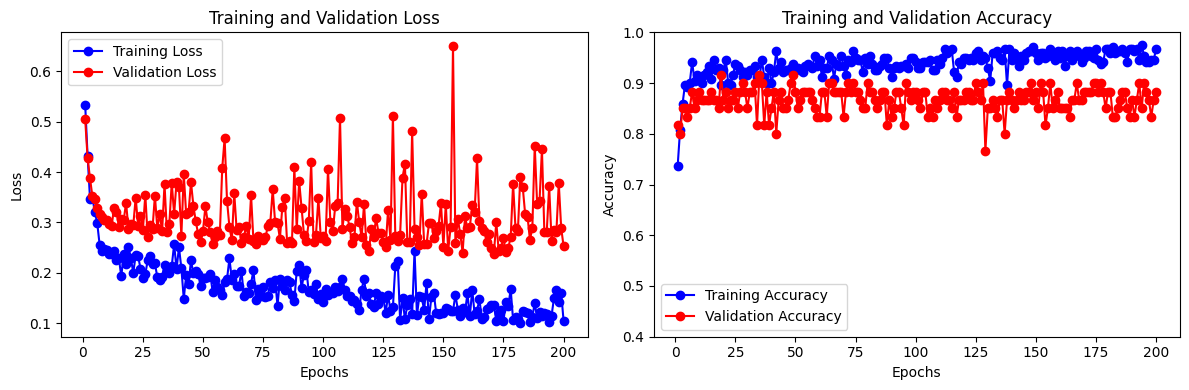

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.91      0.93      0.92        44
         out       0.80      0.75      0.77        16

    accuracy                           0.88        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.88      0.88      0.88        60

==========Cross Validation Fold 5==========
trainLoss: 0.5905 Acc: 0.6833
valLoss: 0.3122 Acc: 0.9000
trainLoss: 0.3769 Acc: 0.8583
valLoss: 0.2430 Acc: 0.9333
trainLoss: 0.3234 Acc: 0.8792
valLoss: 0.2086 Acc: 0.9500
trainLoss: 0.2803 Acc: 0.9042
valLoss: 0.1897 Acc: 0.9500
trainLoss: 0.2597 Acc: 0.9083
valLoss: 0.1850 Acc: 0.9333
trainLoss: 0.2615 Acc: 0.8875
valLoss: 0.1770 Acc: 0.9500
trainLoss: 0.2565 Acc: 0.9167
valLoss: 0.1859 Acc: 0.9000
trainLoss: 0.2525 Acc: 0.9083
valLoss: 0.1619 Acc: 0.9667
trainLoss: 0.2855 Acc: 0.9042
valLoss: 0.1640 Acc: 0.9333
trainLoss: 0.2311 Acc: 0.9042
valLoss: 0.1794 Acc: 0.9500
trainLoss: 0.2142 Acc: 0

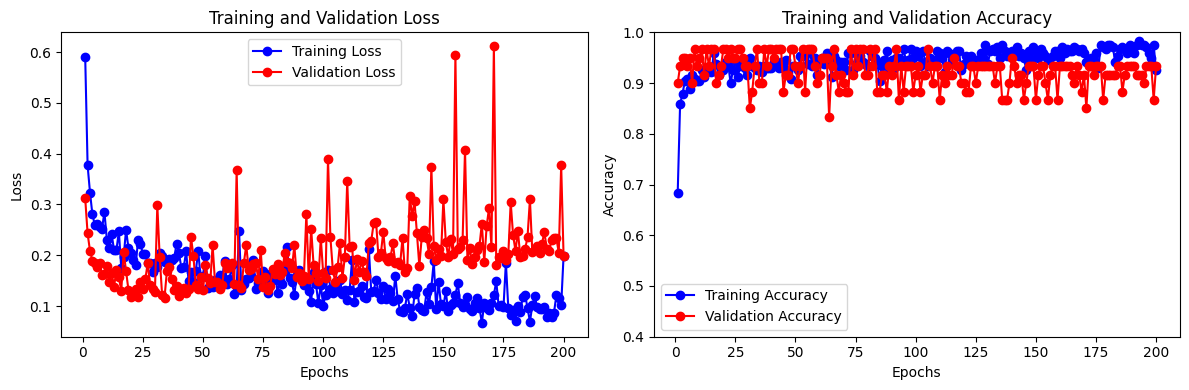

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.94      0.98      0.96        45
         out       0.92      0.80      0.86        15

    accuracy                           0.93        60
   macro avg       0.93      0.89      0.91        60
weighted avg       0.93      0.93      0.93        60



In [119]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier[6] = nn.Linear(4096, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))